Nome: Gustavo Duarte Serafim

RA: 11054016

Disciplina: Filtragem Adaptativa

Professor: Ricardo Suyama

# Laboratório 3 - Parte 3

In [0]:
# Imports do notebook

import numpy as np
from numpy import matlib as matlab
from numpy.fft import fft
import math
from scipy.signal import lfilter as filter
import scipy.signal as signal
import matplotlib.pyplot as plt

# Trecho pra permitir gráficos interativos... (vai instalar um pacote)
#!pip install -q mpld3
#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

## 7. Refaça as simulações considerando agora três sinais senoidais (frequências em 30, 50 e 70 Hz) somados. Adicione a este sinal composto o ruído, como no exemplo anterior. O que ocorre com o filtro obtido pelo algoritmo? Mostre a superfície da função custo de Wiener, assim como as curvas de nível da função custo.

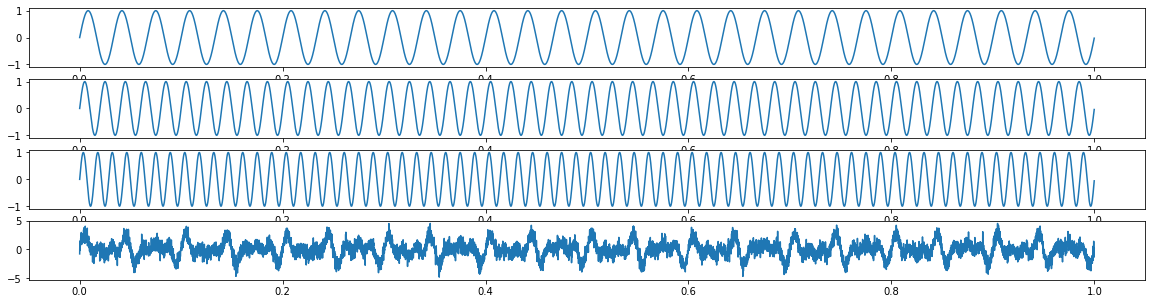

In [18]:
# Parâmetros do sinal
Fs = 8000       # Freq. de amostragem
f1 = 30         # Freq.
f2 = 50         # Freq.
f3 = 70         # Freq.
T = 1           # Período (segundos)
desv_pad = 0.5  # Desvio padrão do ruído

t = np.arange(0, T, 1/Fs)
x1 = np.sin(2*np.pi*f1*t)
x2 = np.sin(2*np.pi*f2*t)
x3 = np.sin(2*np.pi*f3*t)
x = x1+x2+x3
ruido = np.sqrt(desv_pad)*np.random.randn(len(t))

plt.figure(figsize = [20, 5])
plt.subplot(4, 1, 1)
plt.plot(t, x1)
plt.subplot(4, 1, 2)
plt.plot(t, x2)
plt.subplot(4, 1, 3)
plt.plot(t, x3)
plt.subplot(4, 1, 4)
plt.plot(t, x+ruido)
plt.show()

In [0]:
# Parte a - Implementação da Função do algoritmo LMS 

def Least_Mean_Square(x, d, L = 2, mu = 0.001, partida = [0 for n in range(0, 100)]): 
  #Obs: a inicialização da partida é uma gambiarra pra funcionar até 100 coeficientes... 

  nCoeffs = L
  partida = partida[0:L]

  # Construindo a matriz X dos coeficientes de x(n) ... x(n-L+1): 
  X = matlab.repmat(x.transpose(), nCoeffs, 1)
  for i in np.arange(0, nCoeffs): 
    X[i][:] = np.roll(X[i][:], [0, i-nCoeffs+1])
  X = X[:, 0:np.size(X, 1)-nCoeffs+1]

  # O mesmo com d(n)
  d = d[nCoeffs-1:d.size]
  
  # Inicialização do filtro 
  w_LMS = np.zeros((nCoeffs,1))
  w_LMS[:, 0] = partida

  # Inicialização da matriz que armazenará a evolução dos valores de w_SD
  w_LMS_hist = np.zeros((nCoeffs,X[0].size))

  for i in range(0, X[0].size): 
    y_LMS = np.dot(w_LMS.transpose(), X[:, i])
    e = d[i] - y_LMS;
    w_LMS = w_LMS + 2*mu*X[:, i].reshape(nCoeffs,1)*e;
    w_LMS_hist[:, i] = w_LMS.reshape(nCoeffs,)

  return w_LMS, w_LMS_hist

0.08636230665606398


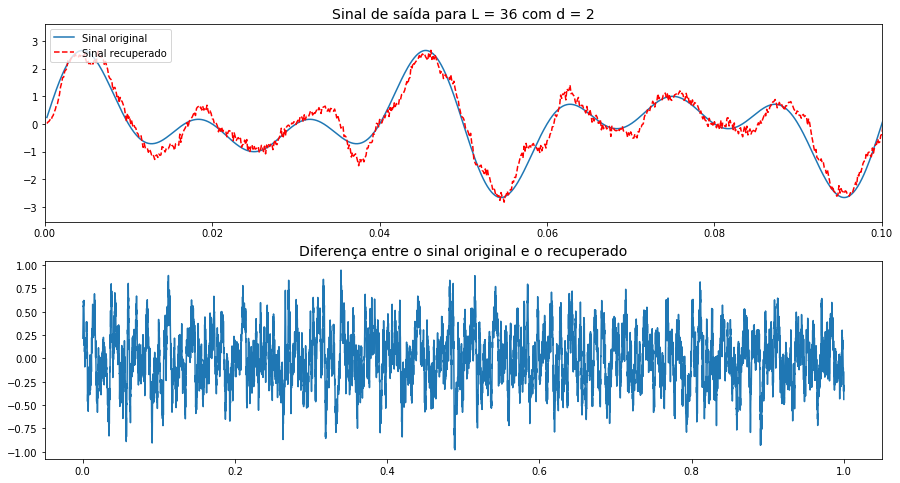

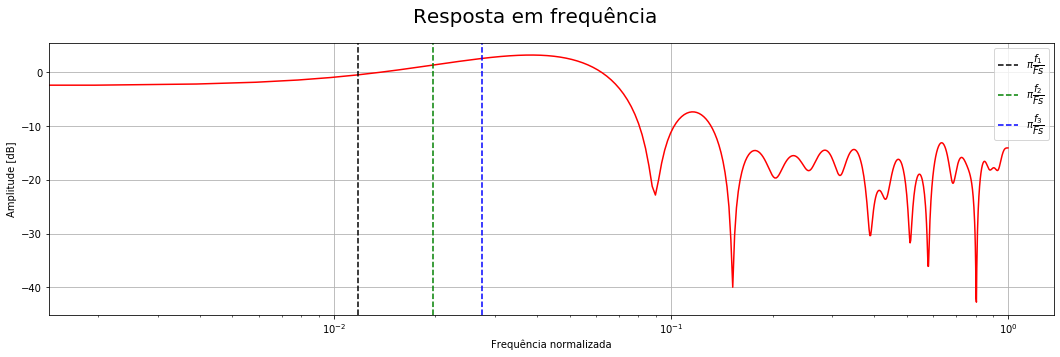

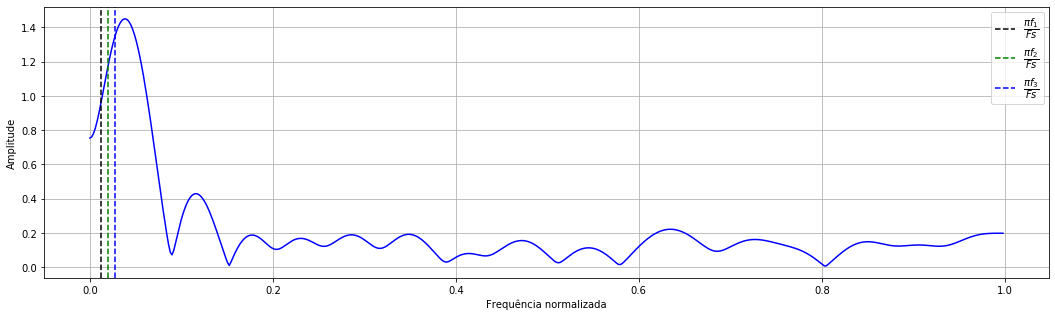

In [20]:
# Parte b - Modelagem dos sinais atrasados

atraso = 2
num = np.zeros(atraso) 
num[atraso-1] = 1 # Numerador da função de transferência: [0 0 0 0 ... 0 1]

# Cálculo do sinal atrasado + eliminação do sinal indesejado (primeiros indices)
x_atrasado = filter(num, [1], x + ruido) # filtrando x com o ruído
x_atrasado = x_atrasado[atraso:len(x_atrasado)]
t_atrasado = t[atraso:len(t)]                   # cálculo de t(n-d)
x_original = x[atraso:len(x)]                   # cáçculo de x(n-d)
d = (x+ruido)[atraso:len(x)]                    # definição do sinal desejado

# Parte c - Implementação do preditor variando o número de parâmetros do preditor...

# Cálculo dos coeficientes
# Passo de adaptação constante definido na função
num_param = 36

w, w_hist = Least_Mean_Square(x_atrasado, d, num_param)

# Construção da função de transferência do filtro FIR
num = [w[i][0] for i in range(0, len(w))]  # [w(0), w(1), w(2), ... , w(L-1)]

y = filter(num, [1], x_atrasado) # Calculando a saída y = w*x(n-d)

print(np.var(y-x_original))

plt.figure(figsize = [15, 8])
plt.subplot(2, 1, 1)
plt.plot(t_atrasado, x_original, label = 'Sinal original')
plt.plot(t_atrasado, y, 'r--', label = 'Sinal recuperado')
plt.title('Sinal de saída para L = '+str(num_param)+' com d = '+str(atraso), fontsize = 14, )
plt.xlim(0, 0.1)
plt.legend(loc = 'upper left')

plt.subplot(2, 1, 2)
plt.title('Diferença entre o sinal original e o recuperado', fontsize = 14, )
plt.plot(t_atrasado, x_original-y)
#plt.xlim(0, 0.1)
#plt.ylim(-1.1, 1.1)

plt.show()

# Resposta em frequência dos filtros obtidos... 

W_z, H_z = signal.freqz(num, 1)

plt.figure(figsize = [18, 5])
plt.suptitle("Resposta em frequência", fontsize = 20)
plt.semilogx(W_z/np.pi, 20*np.log10(abs(H_z)), color = 'r')
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequência normalizada')
plt.axvline(x=(np.pi*f1/Fs), color = 'k', linestyle = '--', label = '$\pi \dfrac{f_1}{Fs}$')
plt.axvline(x=(np.pi*f2/Fs), color = 'g', linestyle = '--', label = '$\pi \dfrac{f_2}{Fs}$')
plt.axvline(x=(np.pi*f3/Fs), color = 'b', linestyle = '--', label = '$\pi \dfrac{f_3}{Fs}$')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize = [18, 5])
plt.plot(W_z/np.pi, abs(H_z), color = 'b')
plt.ylabel('Amplitude')
plt.xlabel('Frequência normalizada')
plt.axvline(x=(np.pi*f1/Fs), color = 'k', linestyle = '--', label = '$\dfrac{\pi f_1}{Fs}$')
plt.axvline(x=(np.pi*f2/Fs), color = 'g', linestyle = '--', label = '$\dfrac{\pi f_2}{Fs}$')
plt.axvline(x=(np.pi*f3/Fs), color = 'b', linestyle = '--', label = '$\dfrac{\pi f_3}{Fs}$')
plt.legend()
plt.grid()

plt.show()